<a href="https://colab.research.google.com/github/ImperialCollegeLondon/ReCoDE-AIForPatents/blob/main/docs/1_Introduction_and_Data_Handling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Natural Language Processing for Classifying Patent Text Using Tensorflow - Introduction

From this notebook you will learn:
- Why we need to classify patents.
- What is Tensorflow?
- Loading datasets into your workspace.
- What Tokenisation, Vectorisation and Word Embeddings are in the context of NLP.
- Methods to analyse and understand a dataset.
- Training a model using the Term-Frequency - Inverse Document Frequency (TF-IDF) vectorisation technique with a Multinomial Bayes algorithm.

# Why do we need to classify Patents, and how can NLP help?

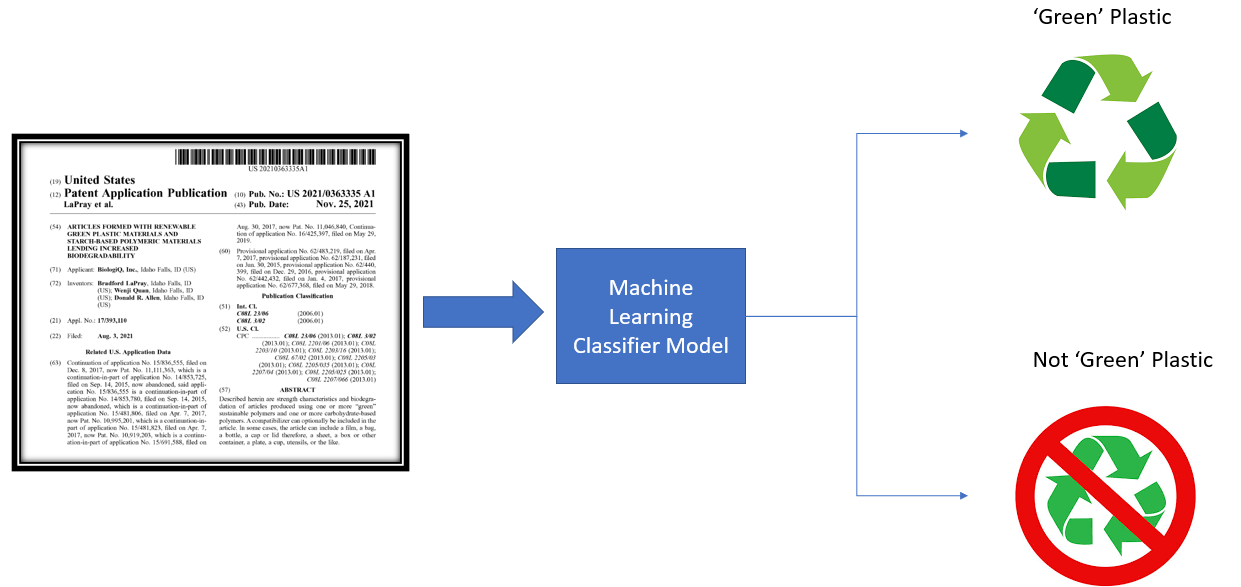

There were 193,460 European patent applications filed at the European Patent Office in [2022](https://www.epo.org/about-us/annual-reports-statistics/statistics/2022.html#:~:text=Record%20demand%20for%20European%20patents,more%20secure%20energy%20systems%20intensified.).

The EPO, and several other agencies are really interested in trends associated with the filings of patents to specific areas such as ‘Green Plastics’ (e.g., plastics that can be recycled, or that are made from biodegradable materials).

Typically, to identify whether a patent is related to a certain topic or not, a person would have to manually read through a patent application and assign classification labels to it based on their opinions. Patent applications can be hunderds of pages long, and with the sheer amount of applications that the EPO receive annually, it's easy to see why patent classification is a tedious task!

Hence, there is a need for quick and robust methods of accurately classifying the plethora of patents being submitted to the EPO to highlight any trends in ‘Green Plastics’ filings, or filings in any other areas of interest (e.g., renewable energies, artificial intelligence, augmented reality, drug discovery)

By employing machine learning, in the form of Natural Language Processing algorithms, the cost, and likelihood of misclassification of patents, in any technical area, can be significantly reduced, while speeding up the process.

#The EPO CodeFest - Classifying Patents Related to Green Plastics

To address the challenge of classifying patents, the EPO held its first ever [Codefest](https://www.epo.org/news-events/in-focus/codefest.html), where it challenged entrants to develop creative and reliable artificial intelligence (AI) models for automating the identification of patents related to green plastics.

To enable contestants to develop their models, the EPO provided access to its [extensive dataset](https://www.epo.org/searching-for-patents/data/bulk-data-sets.html) of patents and patent classifications. From this, we created a  smaller, binary classification dataset, with half of the entries being related to patents, and the other half being related to other patent areas.

#What is Tensorflow?

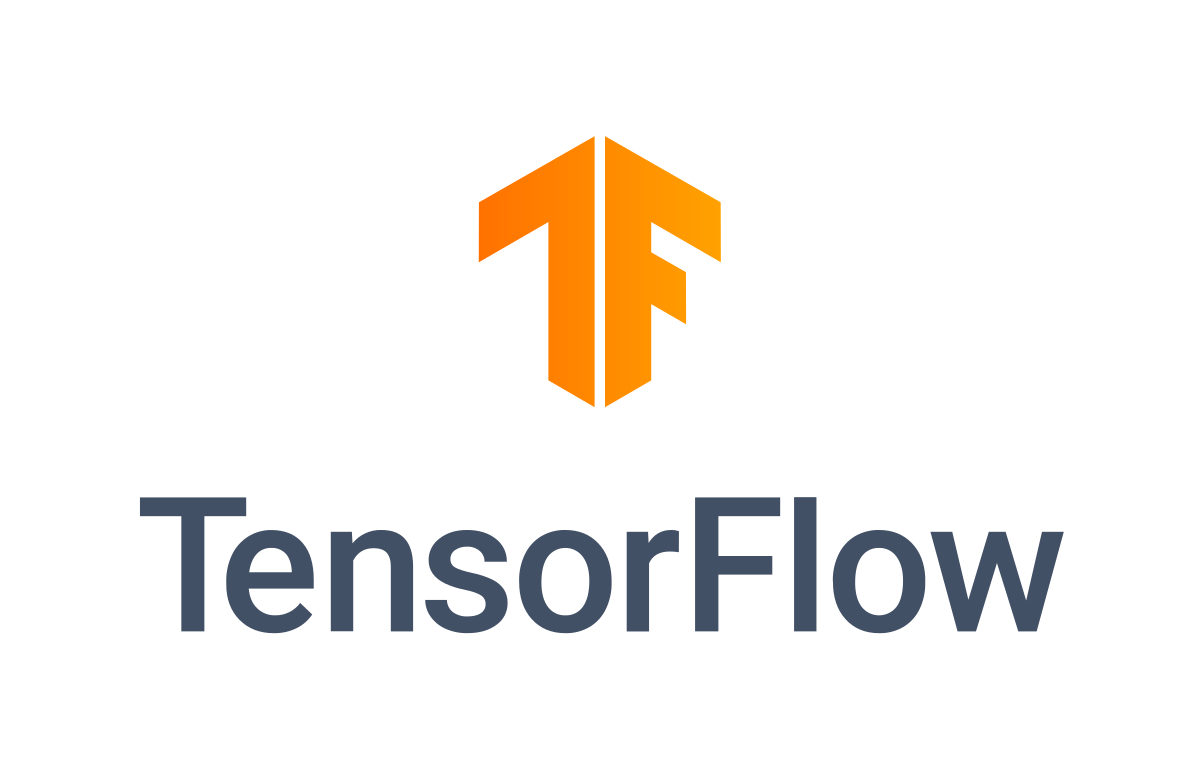

[TensorFlow](https://www.tensorflow.org/) is an open-source machine learning framework developed by Google. It provides a comprehensive set of tools, libraries, and resources for building and deploying machine learning models. Advantages of using Tensorflow include:

- Flexibility: TensorFlow offers a high level of flexibility, allowing developers to build and train models using a variety of approaches. It supports both high-level APIs, such as Keras (which is what we will primarily be using in this ReCoDE exemplar), for ease of use, and lower-level APIs for more control and customization.

- Community and ecosystem support: TensorFlow has a large and active community of developers, researchers, and users. This results in extensive online resources, tutorials, and forums for learning and troubleshooting. The community also contributes to the development of new features, bug fixes, and optimizations, ensuring continuous improvement of the framework.

- Comprehensive ecosystem: TensorFlow provides a rich ecosystem of tools and resources to support the entire machine learning workflow. This includes data preprocessing, model building, training, deployment, and monitoring. It also integrates well with other popular frameworks and libraries, making it easy to combine TensorFlow with existing tools.

It's worth noting that the choice of machine learning framework depends on the specific requirements and preferences of the project. Other frameworks, such as PyTorch and JAX, also have their own advantages, so it's important to consider the specific needs of your project before making a decision on which framework to use.

## Importing modules that we will be using.

In [1]:
!git clone https://github.com/ImperialCollegeLondon/ReCoDE-AIForPatents.git

Cloning into 'ReCoDE-AIForPatents'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 229 (delta 54), reused 32 (delta 20), pack-reused 145
Receiving objects: 100% (229/229), 34.37 MiB | 14.60 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import random
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import tensorflow_hub as hub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Loading data into the notebook

In the majority of cases, when working with large datasets, we will have to load the data into the notebook, or script, we are working with in order to manipulate it for use with a machine learning algorithm. Datasets for NLP tasks will most likely come in one of the following forms:

- .csv (Comma Separated Variable file)
- .xlsx (Excel file)
- .txt (Text file)
- .json (JavaScript Object Notation file)

Depending on the file type that the dataframe is stored in, we would need to read the file into the notebook/script in slightly different ways. In our case, we are working exclusively with CSV files.

Let's start by loading in a couple of the files related to green plastics and non-green plastics into pandas dataframes. We will also look at how many entries are in each dataframe.

In [4]:
 Green_Dataframe = pd.read_csv('/content/ReCoDE-AIForPatents/Datasets/GreenPatents_Dataset.csv')
 NotGreen_DataFrame = pd.read_csv('/content/ReCoDE-AIForPatents/Datasets/NotGreenPatents_Dataset.csv')

 print(f'There are {len(Green_Dataframe)} patent abstracts related to "Green" Plastics.')
 print(f'There are {len(NotGreen_DataFrame)} patent abstracts related to "Not Green" plastics.')

There are 74703 patent abstracts related to "Green" Plastics.
There are 205715 patent abstracts related to "Not Green" plastics.


So from our initial look at the two datasets, we have an imbalance between patent abstracts related to 'Green Plastics' and abstracts **not** related to 'Green Plastics'.

In practice, datasets aren't balanced, and having imbalanced datasets may lead to poorer performance of our classifcation algorithm, so let's write a short function that:

- Ensures equal amounts of entries for both classes.

- Merges the dataframes together (which will make it easier to feed into our models later on).

- Shuffles the dataset (if we don't do this, our model may see all the non-green patents (or vice-versa) first, meaning that may struggle to learn the difference between non-green plastic abstracts and green plastic abstracts later down the line).

#### **Extra Reading**:

If you want to learn more about the benefits of shuffling your datasets before training ML models, read this article:

[Shuffle Your Dataset to Improve Accuracy of Predictions](https://python.plainenglish.io/shuffle-your-dataset-to-improve-accuracy-of-predictions-eff02da07daa)

In [5]:
def loaddata(GreenCSV, NotGreenCSV):
  """
  Function to load files with training entries into your object space as a
  dataframe

  GreenCSV: Path to Green Patents CSV
  NotGreenCSV: Path to Non Green Patents CSV
  """
  #Read in first dataframe
  GreenData_Dataframe = pd.read_csv(GreenCSV)

  #Read in second dataframe
  NotGreenDataFrame = pd.read_csv(NotGreenCSV)

  #Make sure equal number of entries
  MergedDataFrame = pd.concat([GreenData_Dataframe,
                               NotGreenDataFrame[0:len(GreenData_Dataframe)]])

  #Shuffle dataframe
  FinalDataframe = MergedDataFrame.sample(frac=1, random_state=25)
  return FinalDataframe

FinalDataframe = loaddata('/content/ReCoDE-AIForPatents/Datasets/GreenPatents_Dataset.csv',
                          '/content/ReCoDE-AIForPatents/Datasets/NotGreenPatents_Dataset.csv')

print(FinalDataframe)

                                                Abstract  GreenV
70933  utility model belongs technical field tea prod...       1
46474  invention relates nitronatrite comprehensive u...       1
73835  present invention discloses gradients methods ...       0
32305  invention discloses treatment method extractin...       1
65748  utility model discloses kind degradable food p...       1
...                                                  ...     ...
55662  twoway opening modular decklid assembly disclo...       0
17600  device guiding boring instrument pilot hole pe...       0
6618   packing method machine producing sealed packag...       1
15727  invention provides display device comprising s...       0
29828  provide method apparatus removing radioactive ...       1

[149406 rows x 2 columns]


**NB: The abstracts related to Green Plastics have the label '1' while those not related have the label '0'. This will become important later down the line, when we are trying to interpret the outputs of our trained models.**

# Removing Duplicate and Not-a-Number (Nan) Entries
With large datasets, it is often the case that we will have duplicated entries. This can be a problem as duplicated entries may bias the model during training. As for Nan values, they by definition contain no information, so there's no point using such entries to train our models. Let's check for duplicate entries (by checking for duplicate abstracts in our ['Abstracts'] column) and Nan values, and delete them.

In [6]:
# Checking for duplicates
total_duplicate_titles = sum(FinalDataframe["Abstract"].duplicated())
print(f"There are {total_duplicate_titles} duplicate titles.")

There are 116 duplicate titles.


In [7]:
# Deleting duplicates
FinalDataframe = FinalDataframe[~FinalDataframe["Abstract"].duplicated()]

#Deleting Nan values
FinalDataframe = FinalDataframe.dropna()

print(f"There are {len(FinalDataframe)} rows in the deduplicated dataset.")

There are 149289 rows in the deduplicated dataset.


Now that we have removed duplicates and Nans, we should have a dataset just under 150k examples of patent abstracts that are close to perfectly split between our two classes. However, we can't just feed our dataset into a model like this. To allow ML models to learn, we need to feed them inputs in the form of numbers (that's the only input format they can understand).

When converting inputs into formats for use with machine learning models, there are three key concepts that we must be aware of:

1. Tokenisation
2. Vectorisation
3. Word Embeddings

Now, we are going explore in more detail exactly what these NLP techniques are and how they help machine learning models learn.

#Tokenisation

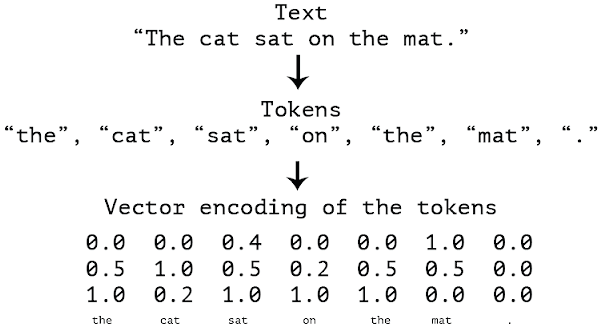

Source [Deep Learning with Python by François Chollet](https://freecontent.manning.com/deep-learning-for-text/)

Tokenization refers to the process of breaking down a piece of text into smaller units called tokens. These tokens can be words, characters, or even subwords, depending on the chosen tokenization strategy. The purpose of tokenization is to provide a structured representation of text that can be easily converted into a format for learning  by a machine learning model.

An example of this is shown in Figure 1.

For example, given the sentence: "The cat sat on the mat", a simple word-based tokenization would result in the tokens: ["The", "cat", "sat", "on", "the", "mat"]. Each token represents a discrete unit of meaning within the sentence.

Let's implement an example of word tokenisation using our dataset.

In [8]:
#Number of entries to tokenise from dataset
Number_of_Entries = 1

for i in range(1, Number_of_Entries+1):
  #Get an entry from the dataframe
  EntryDataframe = FinalDataframe.iloc[i]

  #Get the entry's abstract
  EntryAbstract = EntryDataframe['Abstract']

  print(f'Orginal Abstract: \n{EntryAbstract}\n')

  #Split abstract up by spaces between words
  TokenisedEntry = EntryAbstract.split(' ')

  print(f'Tokenised Abstract: \n{TokenisedEntry}')

Orginal Abstract: 
invention relates nitronatrite comprehensive utilization method simplifies mining improves efficiency reduces cost according single production sodium nitrate brine extended potassium iron powder gold concentrate sand main steps follows heading machine used broken enters mill milling water added milled matters mixture mineral passes magnetic separation conveyed pump centrifuge liquid separated high frequency linear dehydration sieve heavy mass enter table concentrator enrichment pumped storage pool concentrated gramsliter circulation concentration tailings classifier secondary washing conveyor belt tailing pile circulating reservoir standby use ore rate low remarkable economical benefit

Tokenised Abstract: 
['invention', 'relates', 'nitronatrite', 'comprehensive', 'utilization', 'method', 'simplifies', 'mining', 'improves', 'efficiency', 'reduces', 'cost', 'according', 'single', 'production', 'sodium', 'nitrate', 'brine', 'extended', 'potassium', 'iron', 'powder', 'g

**TRY IT YOURSELF**

*Change `Number_of_Entries` to tokenise more entries from the dataset. Are there any cases where the for loop doesn't accurately split words up?*

#Data Augmentation for NLP

You may have noticed that the printed abstracts above have weird grammar. That's because we performed some data augmentation (removing stopwords and punctuation) before feeding the data to the models.

In NLP, removing stopwords and punctuation is a common preprocessing step that involves eliminating common words that often occur in a language but typically do not carry significant meaning or semantic value in a given context. Stopwords include "the," "is," "and," "a," "an," "in,". The main purpose of removing stopwords during NLP are as follows:

- Noise Reduction: Stopwords and punctuation often appear frequently in text but do not contribute much to the overall meaning or context. By removing them, the data becomes cleaner, and the focus shifts to the more meaningful words, which can improve the performance of NLP tasks.

- Improved Efficiency: Removing stopwords and punctuation reduces the number of words and characters in the dataset. This can lead to faster processing times and lower memory requirements, making the NLP algorithms more efficient.

- Lower Dimensionality: As we will see, text data is often represented in high-dimensional vector spaces, such as word embeddings or bag-of-words representations. Removing stopwords and punctuation reduces the dimensionality of the data, making it more manageable and easier to process.

- Language Consistency: By removing punctuation, the text becomes more standardized, which can be particularly important for tasks like sentiment analysis, topic modeling, and machine translation. Consistent text can help improve the accuracy and generalizability of NLP models.

- Better Tokenization: Removing punctuation can aid in proper tokenization, ensuring that words are correctly represented without attached punctuation marks.

It's important to note that while removing stopwords and punctuation can be beneficial in many cases, the decision to perform these preprocessing steps depends on the specific NLP task and the characteristics of the dataset. In some cases, keeping stopwords and preserving certain punctuation might be essential to capture specific linguistic nuances and contextual information.

Let's have a look at how we can use python to remove stopwords and punctuation from text by taking a raw abstract from Google Patents, and defining a function to clean abstracts using the [`nltk`](https://www.nltk.org/) NLP library.

In [9]:
"""
nltk has an in-built stopword list so that we don't have to create our own. You
can access it by instantiating a list object as shown below.
"""
all_stopwords = nltk.corpus.stopwords.words('english')

"""
You can add extra stopwords to be removed from dataset/input abstracts by defining
the extra words as elements in a list, then extending the list object we created
above.
"""
extra_stopwords = ['ii', 'iii']

all_stopwords.extend(extra_stopwords)

print(all_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
def clean_data(input):
  """
  As preparation for use with the classifcation models, this function removes
  superfluous data from an input string. Input should be in string form.
  """

  # splits abstracts into individual tokens to allow removal of stopwords by list comprehension
  text_tokens = nltk.tokenize.word_tokenize(input)

  # List comprehension to remove stopwords
  Stopword_Filtered_List = [word for word in text_tokens if not word in all_stopwords]

  # returns abstract to string form
  Stopword_Filtered_Abstract = (" ").join(Stopword_Filtered_List)

  #Define characters to remove from abstract
  RemovedCharacters = ['[', ']', '{', '}', ';', '(', ')', ',', ',', '.',
                       ':', '/', '-', '#', '?', '@', '£', '$', '%']

  # List comprehension to remove unwanted characters
  Character_Filtered_Abstract = [word for word in Stopword_Filtered_Abstract
                                 if not word in RemovedCharacters]

  # Returns abstract to string form for next stage of processing
  Character_Filtered_Abstract_String = ''.join(Character_Filtered_Abstract)

  # Split abstracts by blank space in preparation for next step
  Character_Filtered_Abstract_Tokens = Character_Filtered_Abstract_String.split(' ')

  # Lowercasing all words in the abstract
  Character_Filtered_Abstract = [word.lower() for word in Character_Filtered_Abstract_Tokens]

  Abstract_RemovedNumbers  = []

  #For loop to remove numbers from abstract
  for Word in Character_Filtered_Abstract:

      Token = list(Word)

      #Check if token is a number
      Token = [x.isnumeric() for x in Token]

      #Check if
      if True in Token:
          continue
      else:
          #Add token to list if it is not a number
          Abstract_RemovedNumbers.append(Word)

  #Returns abstract to string form
  Cleaned_Abstract = ' '.join(Abstract_RemovedNumbers)
  return Cleaned_Abstract

Let's see the effect that our function has on an [abstract](https://patents.google.com/patent/US11046840B2/).

In [11]:
test_abstract = """
Described herein are methods for rendering biodegradable a plastic material that
is not itself biodegradable, by blending the plastic material with a carbohydrate-based
polymeric material that is formed from one or more starches, and a plasticizer
(e.g., glycerin). The carbohydrate-based polymeric material is less crystalline
than the starting starch materials, e.g., being substantially amorphous,
and having a crystallinity of no more than 20%. Third party testing shows blends
of such materials render the entire blend biodegradable, believed to be due to the
low crystalline substantially amorphous carbohydrate-based polymeric material breaking
the hygroscopic barrier associated with the non-biodegradable plastic material, so
that when blended together, both the plastic material and the carbohydrate-based
polymeric material are biodegradable.
"""

Cleaned_Abstract = clean_data(test_abstract)
print(Cleaned_Abstract)

described herein methods rendering biodegradable plastic material biodegradable  blending plastic material carbohydratebased polymeric material formed one starches  plasticizer  eg  glycerin   the carbohydratebased polymeric material less crystalline starting starch materials  eg  substantially amorphous  crystallinity   third party testing shows blends materials render entire blend biodegradable  believed due low crystalline substantially amorphous carbohydratebased polymeric material breaking hygroscopic barrier associated nonbiodegradable plastic material  blended together  plastic material carbohydratebased polymeric material biodegradable 


#Text Vectorisation

Text vectorization refers to the process of converting text documents into numerical feature vectors. It represents each document as a vector, where each element of the vector represents a specific feature or attribute of the text. Some commonly used text vectorization techniques include:

- [Bag-of-Words](https://machinelearningmastery.com/gentle-introduction-bag-words-model/) (BoW): This technique represents a document as a set of its constituent words, ignoring the order and context. Each word in the vocabulary is assigned a unique index, and the vector representation counts the frequency of each word in the document.

- [Term Frequency-Inverse Document Frequency](https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558) (TF-IDF): This technique represents a document by the importance of each word within the document and across the entire corpus. It assigns higher weights to words that appear frequently within a document but less frequently across other documents.

- [N-grams](https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058): This technique considers sequences of 'n' words as a feature, capturing some level of local word order.

Text vectorization techniques treat each word or n-gram as a separate feature, and the resulting vectors are often high-dimensional, sparse, and may not capture the semantic relationships between words. These techniques are simple and interpretable but lack the ability to capture complex linguistic structures and meanings.

Let's implement a bag-of-words text vectoriser using Tensorflow.


#Splitting a Dataset into Training and Test

In normal machine learning workflows, before vectorising your data, one would split the dataset up into training and test subsets.

The training set is the portion of the dataset that is used to train the model. It contains a labeled collection of input data and their corresponding output or target values.

The test set is a separate dataset that the model has not seen during training. The purpose of the test set is to assess the model's generalization performance, that is, how well it can make predictions on new, unseen data.

We will use [scikit_learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)'s `train_test_split()` function to perform the split, setting a `test_size` of 0.1, meaning that 10% of the dataset will be used for testing, and the remaining 90% for training.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(FinalDataframe["Abstract"].to_numpy(),
                                                              FinalDataframe["GreenV"].to_numpy(),
                                                              test_size=0.1, # 10% of sample in test dataset
                                                              random_state=25)

print(f'There are {len(X_train)} entries in the training dataset.')
print(f'There are {len(X_test)} entries in the test dataset.')

There are 134360 entries in the training dataset.
There are 14929 entries in the test dataset.


As shown by the outputs of the cell above, we have now split our large dataset into training and test sets, with a 90-10 split to training and test entries respectively.

## The Tensorflow TextVectorisation Layer

The Tensorflow Text Vectoriser allows us to quickly vectorise examples in a dataset an assign each unique word a corresponding unique value. The processing of each example contains the following steps:

1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually n-grams)
4. Index tokens (associate a unique int value with each token)
5. Transform each example using this index, either into a vector using the Python `int` type or a dense `float` vector.

To find out more about text vectorisation in Tensorflow, you can read the documentation:

[Tensorflow TextVectoriser](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

In [13]:
# Setting up the Text Vectoriser
text_vectoriser = TextVectorization(
    # how many words in the vocabulary (all of the different words in your text)
    max_tokens=None,

    # how to process text
    standardize="lower_and_strip_punctuation",

    # how to split tokens
    split="whitespace",

    # create groups of n-words
    ngrams=None,

    # how to map tokens to numbers
    output_mode="int",

    # how long should the output sequence of tokens be?
    output_sequence_length=200)

    # pad_to_max_tokens=True) # Not valid if using max_tokens= None

To make our dataset compatible with Tensorflow's TextVectorisation layer, we need to make sure that all the elements in each entry are of the data type `str` and  that each element is a numpy array. To see why, refer to the documentation.

In [14]:
#Making inputs compatible with TextVectorisation Layer
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]
X_train = np.array(X_train)
X_test = np.array(X_test)

Now that we have prepared the inputs, we can feed it into the TextVectorisation layer by calling its `.adapt()` method on our training data to allow it to compute a vocabulary and assign each unique word a numerical value.

Let's print an example of an abstract before and after vectorisation to see the difference it makes.

In [15]:
"""
Allows our vectoriser object to computes a vocabulary of  all string tokens seen in the dataset.
It's sorted by occurrence count, with ties broken by sort order of the tokens (high to low).
"""
text_vectoriser.adapt(X_train)

#Fetching a random example from the training dataset
Random_Abstract = random.choice(X_train)

print(f"Abstract:\n{Random_Abstract}\n")
print(f"Vectorized Abstract:\n{text_vectoriser([Random_Abstract])}")

Abstract:
present invention relates financial list finishing fields particularly kind perforating binding machine solves disadvantage existing prior art easily metal damage drill bit finance including fuselage bookbinding platform side setting flapper slidably connected except bottom provided electromagnet far one end inductive pickup internally pressing plate moving additionally downside connectivity slot fixed baffle extends edge briquetting matched close canthe detect clipped loose ferromagnetic object adsorption prevent breakage also shift onto hot position drilling required manually align

Vectorized Abstract:
[[   21     2    11  6619  5140  1864  1469   249    53  4678   917    81
    951 10272   596   370   605   294   148   681  2094  2340 18555    20
   2781  5208   595    18   322 16484   992    17  3037    32     5  4612
   1275     3    13  8461  3377  1215   435    37   323   846  3023 10433
    718    52   749   283   161  5185   713   415 28446  1822  9510  2390
   5864

As we can see, after we have passed the abstract through the TextVectoriser layer, each word is given a unique value!

#Vector Embeddings

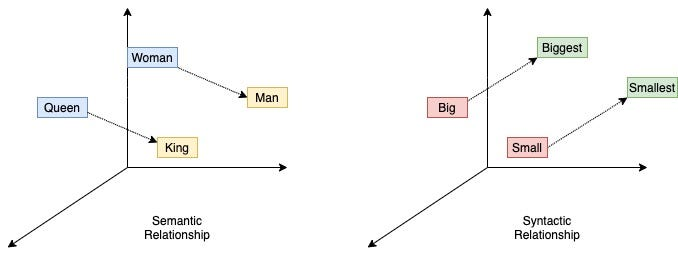

Source [Word2Vec Research Paper Explained](https://https://towardsdatascience.com/word2vec-research-paper-explained-205cb7eecc30)

Word embeddings are dense, low-dimensional, continuous vector representations of words or phrases that capture the semantic and syntactic relationships between them. Unlike text vectorization techniques that represent each word as a separate feature, word embeddings encode contextual and semantic information about words in a continuous vector space, allowing similar words to have similar representations.

Word embeddings are typically learned from large text corpora using techniques like Word2Vec, [GloVe](https://nlp.stanford.edu/projects/glove/), or [FastText](https://fasttext.cc/). These models use neural networks to map words to vector representations based on their co-occurrence patterns in the training data. The learned word embeddings can capture semantic relationships, such as analogies (e.g., king - man + woman ≈ queen) and syntactic relationships (e.g., verb tenses, plural forms, superlatives).

Compared to text vectorization, word embeddings have the advantage of capturing more nuanced and contextual information about words. They can be used to measure word similarity, perform analogical reasoning, and serve as input to more sophisticated NLP models like neural networks.

Let's implement our own version of an vector embedding.


#Making an Embedding using Tensorflow

We can embed text using Tensorflow by constructing an embedding layer.

The parameters that affect the performance of an embedding layer are:

1. `input_dim` - The size of the vocabulary (number of unique words) in our dataset (we will cover how to obtain this later).

2. `output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word. Having a larger feature vector may enable more information to be stored in each feature vector, but this increased information will slow down training, so a balance should be struck.

3. `embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.

4. `input_length` - Length of sequences being passed to embedding layer.




In [16]:
# Setting up an embedding layer

Vocabulary = text_vectoriser.get_vocabulary()
embedding = layers.Embedding(
    # Set input shape, normally length of vocabulary
    input_dim=len(Vocabulary),

    # Set size of embedding vector
    output_dim=200,

    #Randomly assigns values to embedded text according to a normal distribution
    embeddings_initializer="uniform",

    #How long each input is
    input_length=200,

    name="Test_Embedding_Layer")

Let's see what happens when we pass a vectorised abstract through our embedding layer.

In [17]:
# Get a random abstract from training set
RandomAbstract = random.choice(X_train)
print(f'Original Abstract:\n{Random_Abstract}\n')

# Convert a TextVectorised Abstract to a Vector Embedding
sample_embedding = embedding(text_vectoriser([RandomAbstract]))
print(f'Embedded version:\n {sample_embedding}')

Original Abstract:
present invention relates financial list finishing fields particularly kind perforating binding machine solves disadvantage existing prior art easily metal damage drill bit finance including fuselage bookbinding platform side setting flapper slidably connected except bottom provided electromagnet far one end inductive pickup internally pressing plate moving additionally downside connectivity slot fixed baffle extends edge briquetting matched close canthe detect clipped loose ferromagnetic object adsorption prevent breakage also shift onto hot position drilling required manually align

Embedded version:
 [[[-0.01331883  0.04020916 -0.04149691 ... -0.04428054 -0.00257492
    0.03679753]
  [ 0.03950614 -0.02562656 -0.01747006 ... -0.04536198  0.01679728
   -0.04375509]
  [ 0.02542507  0.02316686  0.0041048  ...  0.04491672 -0.01044114
   -0.02465584]
  ...
  [ 0.02872537  0.00132114 -0.00570375 ...  0.04335088 -0.00375735
   -0.03516626]
  [ 0.02872537  0.00132114 -0.00

 As mentioned above, the key difference between text vectorisation and embeddings is that embeddings can be updated during the training of a machine learning model. In other words, the numbers in an embedding can be altered during the training phase of models to better represent the semantic relationships of different words in a dataset's vocabulary, whereas the unique values assigned to each word during text vectorisation remain static.

 Updating these embedding values is how we can train machine learning models to understand language! As you'll see in the model training notebooks, models learn by updating the embedding model, along with other weights and biases in different layers of the model.  

#The Tensorflow Embedding Projector

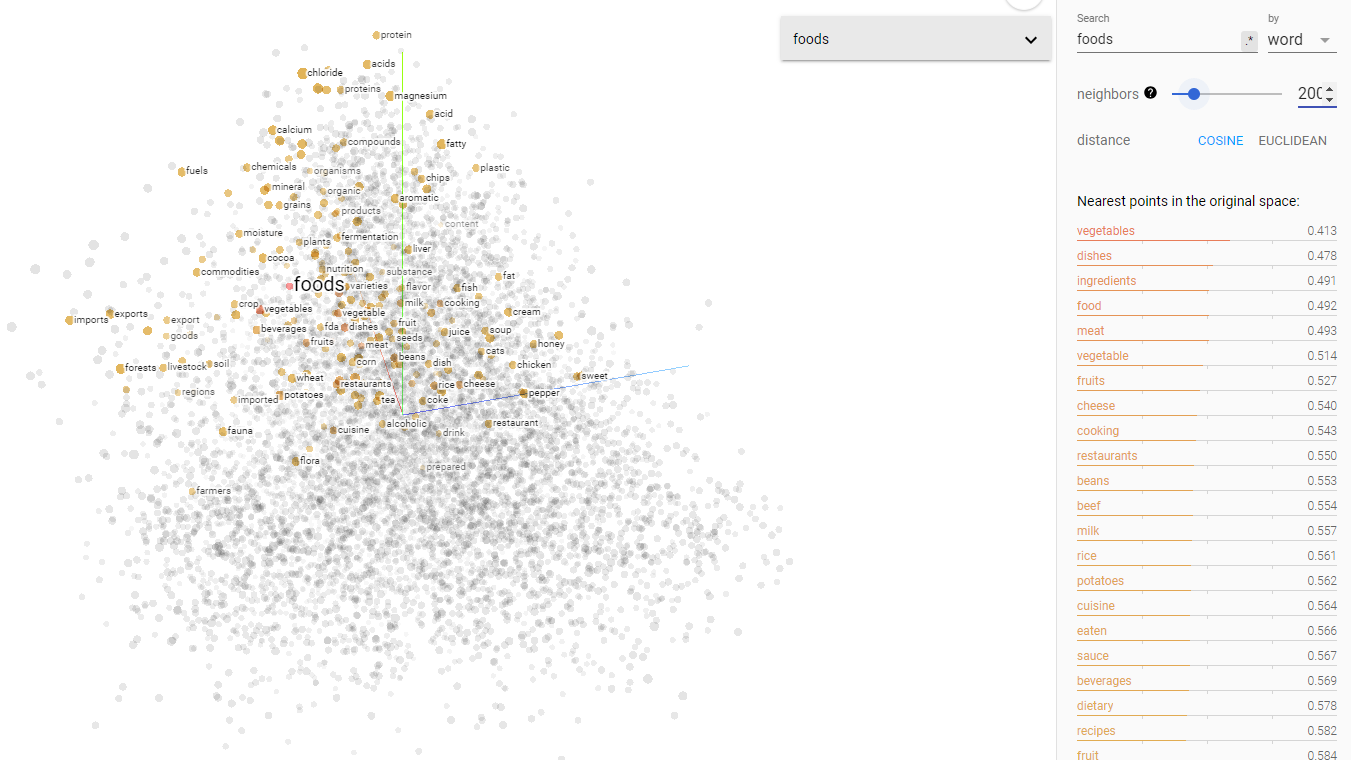

Tensorflow has a really strong community with a suite of amazing tools. One example of this is the Tensorflow embedding projector tool. It shows the learned semantic meanings by the Word2Vec pretrained word embedding, but can be used to represent the learned embeddings of models that you have trained.

The Tensorflow Embedding Projector is interactive, so you can search for a word, such as 'food', and see which words the Word2Vec embedding thinks are most related to the selected word, such as 'vegetables', 'dishes', and 'ingredients' in the search above.

If we consider the embedding of the random abstract we created above, if we embedded every abstract in our dataset, and plotted them all, we would get an embedding space plot that would resemble the one in the image above. If we trained a model to optimise the embedding layer, our embeddings will gain a better 'understanding' of the relationships between words in our chosen language from our dataset, which will be reflected in better predictions of similar words/abstracts.

You can check it out for yourself here:

[Tensorflow Embedding Projector](https://projector.tensorflow.org/)

**TRY IT YOURSELF**

*See if you can create a visualisation of the embedding that we have made above using the tutorial in the link below. How does it compare to the Word2Vec embedding? How do you think the predictions made by the embeddings will change after it has been trained as part of a model?*

[Visualise your own Embedding in Tensorflow](https://www.tensorflow.org/text/guide/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk)

#Understanding Our Data

Analysing the composition of our dataset is important as it will allow us to make better informed decisions when setting up our model training pipelines, and where necessary, make adjustments to our inputs.

Let's start by getting an estimate at how many unique words or 'tokens' there are in our training dataset. We can do this by calling the `.get_vocabulary()` method on the `text_vectoriser` object we adapted above.

In [18]:
Vocabulary = text_vectoriser.get_vocabulary()
print(len(Vocabulary))

137224


We can see that our dataset contains a lot unique words! Let's see which words are most common, and which appear the least.




In [19]:
# Get the unique words in the vocabulary
top_15_words = Vocabulary[:15] # most common words/tokens in vocabulary
bottom_15_words = Vocabulary[-15:] # Least common words/tokens in vocabulary
print(f"Top 15 most common words: {top_15_words}")
print(f"Bottom 15 least common words: {bottom_15_words}")

Top 15 most common words: ['', '[UNK]', 'invention', 'one', 'comprises', 'provided', 'method', 'includes', 'material', 'device', 'first', 'relates', 'discloses', 'end', 'surface']
Bottom 15 least common words: ['aaliphaticaromatic', 'aalabecddox', 'aaii', 'aaggressive', 'aagent', 'aaee', 'aacvd', 'aact', 'aaco', 'aacaes', 'aac', 'aabbxxyyzzoo', 'aabbcc', 'aabb', 'aaak']


The unknown_token (UNK) is used when what remains of the token is not in the vocabulary, or if the token is too long. It is fairly common to see this, and " " as the most common tokens in an NLP dataset.

From the list of the 15 least common words/tokens, it looks like we have picked up typos and tokens that haven't been properly split.

**TRY IT YOURSELF**

*Is there a way to alter our dataset so that the least common words are removed from the abstract? What effect could removing these words have on the training of our models?*

Next, we can find out about the lengths (in words) of the abstracts in our dataset. To do this, we can iterate through each row of the dataset, calculate the length of each abstract, append this length to a list, and calculate the minimum, maximum, and average length of abstracts in our dataset.

We can also plot the distribution of abstract lengths as a histogram, which will help us to determine the hyperparameters of our models later on.

In [20]:
AbstractLength_List = []

# For loop to get the number of words from each abstract in the
for i in range(len(FinalDataframe)):
  # Get a single row from dataframe, which corresponds to one entry
  Length = FinalDataframe.iloc[i]

  # Get the abstract from each entry
  Length = Length['Abstract']

  # Split each abstract by white space
  Length = Length.split(' ')

  #Get length of abstract
  Length = len(Length)

  #Append length of abstract to list
  AbstractLength_List.append(Length)

#Calculate average length of abstract from list
AverageAbstractLength = np.average(AbstractLength_List)

print(f'The average abstract length is {AverageAbstractLength} words.')
print(f'The longest abstract is {max(AbstractLength_List)} words.')
print(f'The shortest abstract is {min(AbstractLength_List)} words.')

The average abstract length is 47.23913349275566 words.
The longest abstract is 397 words.
The shortest abstract is 1 words.


**TRY IT YOURSELF**

*Can you find a quicker way to iterate through each of the entries in our dataset to find the length of each abstract? (Hint: Use a Lamdda function, or a List Comprehension)*

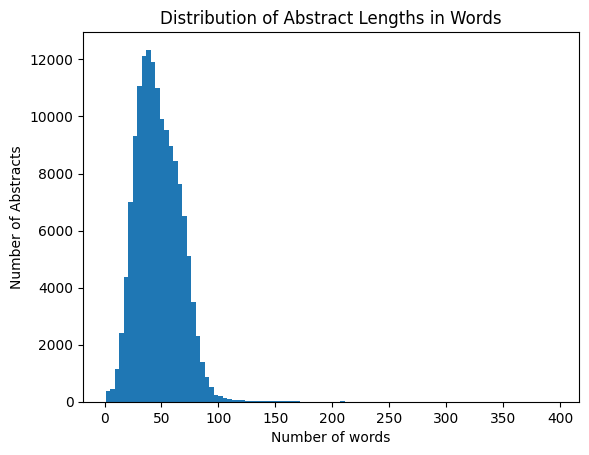

In [21]:
#Using Matplotlib.pyplot to plot the distribution of abstract lengths in our dataset

plt.hist(AbstractLength_List, 100)
plt.title('Distribution of Abstract Lengths in Words')
plt.xlabel('Number of words')
plt.ylabel('Number of Abstracts')
plt.show()

As we can see, there is quite a range of abstract lengths in our dataset. It's unlikely that our model will be able to learn much from a 1 word abstract, and an abstract of 400 words may contain too much information for our models to make an accurate prediction.

**TRY IT YOURSELF**

*See if you can make our dataset better by removing the outlier length abstracts.*

From our histogram, we can see that the majority of abstract are less than 200 words, so we can this number as the dimension of our feature space when creating embedding layers in our model training notebooks.

Now that we are more familiar with our data, let's see if it can be used to train a model!

#Creating a Baseline Model: Term Frequency - Inverse Document Frequency with Naive Bayes

##TF-IDF

The term frequency-inverse document frequency (TF-IDF) algorithm is a numerical statistic used in information retrieval and text mining to figure out the how import a term is within a document or a collection of documents. It tries to measure how relevant a term is to a particular document by considering its frequency in that document and comparing it to its frequency across the entire document collection.

The TF-IDF algorithm consists of two main components:

Term Frequency (TF): It calculates the frequency of a term within a document. The idea is that the more often a term appears in a document, the more important it is to that document.

`TF(t, d) = (Number of occurrences of term t in document d) / (Total number of terms in document d)`

The result is a normalized value representing the importance of the term in the document, ranging from 0 to 1.

Inverse Document Frequency (IDF): It measures the rarity or uniqueness of a term in the entire document collection. Terms that occur frequently across many documents are considered less informative, while terms that occur rarely or only in specific documents are considered more important.

`IDF(t, D) = log((Total number of documents in the collection) / (Number of documents containing term t))`

The IDF is calculated for each term in the document collection, and the result is a numerical value representing the inverse of the term's document frequency. The logarithm is used to dampen the effect of very large document collections.

To obtain the final TF-IDF score for a term in a document, the TF value is multiplied by the IDF value:

`TF-IDF(t, d, D) = TF(t, d) * IDF(t, D)`

The higher the TF-IDF score for a term in a document, the more significant the term is to that document. By applying TF-IDF to all terms in a collection of documents, it is possible to identify important and relevant terms that can be used for various purposes such as document ranking, information retrieval, text classification, and clustering.

TF-IDF cannot help carry semantic meaning. It considers the importance of the words due to how it weighs them, but it cannot necessarily derive the contexts of the words and understand importance that way.

If you want to learn more about TF-IDF, have a look at this article:

[Understanding TF-IDF for Machine Learning](https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/)

##Multinomial Bayes



he Multinomial Naive Bayes classifier is a probabilistic algorithm commonly used for text classification tasks. It is based on the Bayes' theorem and makes an assumption of conditional independence between features (words or terms) given the class labels. Here's a summary of how the Multinomial Naive Bayes classifier works:

- Probability estimation: The classifier starts by estimating the prior probabilities of each class based on the training data. These probabilities represent the likelihood of each class occurring in the dataset (this should be 50-50 in our case).

- Feature likelihood calculation: Next, the classifier calculates the likelihood probabilities for each feature (word or term) within each class. It computes the frequency or occurrence of each feature in the training data for each class and normalizes the counts.

- Naive Bayes assumption: The classifier assumes that the features are conditionally independent given the class labels. This means that the presence or absence of a particular feature does not affect the presence or absence of other features. Although this assumption is usually not true in practice, the classifier simplifies the calculations by assuming independence.

- Class prediction: To classify a new instance, the classifier calculates the posterior probabilities for each class using [Bayes' theorem](https://www.mathsisfun.com/data/bayes-theorem.html). It multiplies the prior probability of each class with the likelihood probabilities of the features observed in the instance. The class with the highest posterior probability is selected as the predicted class.

- Decision rule: In cases where only the class label with the highest posterior probability is needed, the classifier can skip the actual computation of probabilities and focus on comparing the relative values of the class scores. This decision rule, known as the maximum a posteriori (MAP) rule, simplifies the classification process.


The Multinomial Naive Bayes classifier is particularly suited for text classification tasks where features are discrete (e.g., word counts) and the independence assumption is reasonable. It is efficient, scales well to large datasets, and performs surprisingly well in many real-world applications. However, it may not capture complex dependencies between features, which can limit its performance in some scenarios.

If you want to learn more about the maths behind Multinomial naïve Bayes, check out the link below:

[Multinomial Naїve Bayes’ For Documents Classification and Natural Language Processing (NLP)](https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6)

## Implementing a TF-IDF/MultinomialBayes Model

Scikit-learn's [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) class provides a convenient way to chain multiple machine learning algorithms together. It allows you to define a sequence of data preprocessing steps and a final estimator (the algorithm that does the predicting, which in our case is the Multinomial Bayes algorithm), which can be trained and used for making predictions. The purpose of the `Pipeline` is to automate and streamline the machine learning workflow by encapsulating the entire process into a single object.

Here's an overview of how scikit-learn's `Pipeline` works:

1. Defining the preprocessing steps and estimator: Define each step of the pipeline. This typically includes preprocessing steps such as feature scaling, dimensionality reduction, or, as in our case, Text Vectorisation with TF-IDF, followed by an estimator for making predictions.

2. Creating the pipeline: Once you have defined the preprocessing steps and estimator, you create an instance of the `Pipeline` class. The constructor takes a list of tuples, where each tuple represents a step in the pipeline. Each tuple consists of a string identifier for the step and the corresponding preprocessing or estimator object.

3. Training the pipeline: After creating the pipeline, you can train it using the `.fit()` method. This method takes the input data and target values as arguments and applies each preprocessing step in sequence, fitting the estimator to the transformed data.

4. Making predictions: Once the pipeline is trained, you can use it to make predictions on new, unseen data. You can call the `.predict()` method on your trained pipeline object, passing the new data as an argument. The pipeline will automatically apply the preprocessing steps and use the trained estimator to generate the predictions.

By encapsulating the preprocessing steps and the estimator into a single object, the Pipeline class ensures that the same transformations are applied to both the training data and any new data for prediction. This helps to avoid common pitfalls such as data leakage and makes the entire process more robust and reproducible.

In [22]:
#Training a Baseline model using
TFIDF = Pipeline([
    ("tfid", TfidfVectorizer()), #Vectorizer
    ("classifier", MultinomialNB()) #Model
])

TFIDF.fit(X_train, y_train) #Training the MultinomialBayes Model on our dataset

Pipeline(steps=[('tfid', TfidfVectorizer()), ('classifier', MultinomialNB())])

#Evaluating Model Performance



In NLP classication tasks, model evaluation is key to ensuring that trained models are applicable to the tasks they are trained for. Accuracy, Precision, Recall and F1 are common metrics used to assess the quality of ML classification algorithms.

These metrics provide quantitative measures to assess the performance of a machine learning model. They allow us to understand how well the model is performing in terms of prediction accuracy, false positives, false negatives, and overall effectiveness.

Furthermore, these metrics enable us to compare different model architectures to determine which perform best for a given task.

Finally, for classification tasks with imbalanced class distributions, where one class dominates the dataset, accuracy alone may not provide a reliable assessment of a model's performance. Precision, recall, and F1 score offer a more nuanced evaluation by considering both true positives and false positives/negatives, thus accounting for class imbalances and providing a better understanding of the model's effectiveness.

#Evaluation Metrics

So what exactly are the Accuracy, Precision, Recall and F1 metrics...


- Accuracy: Accuracy measures the overall correctness of the model's predictions. It is calculated by dividing the number of correctly predicted instances by the total number of instances in the dataset. Accuracy provides a general view of the model's performance but can be misleading if the dataset is imbalanced.

- Precision: Precision focuses on the positive predictions made by the model and evaluates how many of those predictions are actually correct. It is calculated by dividing the number of true positive predictions by the sum of true positive and false positive predictions. Precision is useful when the cost of false positives is high, and it indicates the model's ability to avoid false positive errors.

- Recall (Sensitivity): Recall measures the model's ability to identify all positive instances correctly. It is calculated by dividing the number of true positive predictions by the sum of true positive and false negative predictions. Recall is important when the cost of false negatives is high, and it reflects the model's ability to avoid false negatives.

- F1 Score: The F1 score combines precision and recall into a single metric by calculating their harmonic mean (a numerical average calculated by dividing the number of observations, or entries in the series, by the reciprocal of each number in the series). It provides a balanced measure of the model's performance by considering both false positives and false negatives. The F1 score is calculated as `2 * ((precision * recall) / (precision + recall))`. It ranges from 0 to 1, where a higher value indicates better performance

Luckily, the scikit-learn library has implementation for calculating of all of these metrics in its `precision_recall_fscore_support()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html), so we can make a function to simultaneously calculate all four of these metrics.

In [23]:
def calculate_model_accuracy(y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred) * 100
  precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

  results = {'accuracy':accuracy,
         'precision': precision,
         'recall': recall,
         'f1': f1_score}

  return results

Let's evaluate our baseline model by calculating the accuracy, precision, recall and F1-Score metrics based on predictions made by the model on our test dataset.  

In [24]:
TFIDF_Results = TFIDF.predict(X_test)
result_baseline = calculate_model_accuracy(y_test, TFIDF_Results)
print(result_baseline)

{'accuracy': 83.61578136512827, 'precision': 0.8366599117341476, 'recall': 0.8361578136512827, 'f1': 0.8361269922833865}


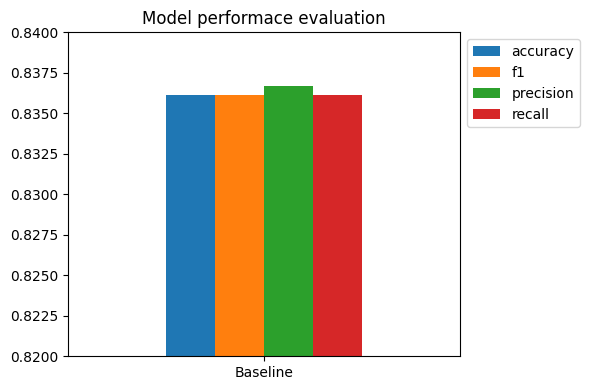

In [25]:
#Plotting the four metrics on a bar chart
all_results = pd.DataFrame({"Baseline": result_baseline})
all_results = all_results.transpose()

#Normalising our accuracy score so we can plot it on the bar chart
all_results["accuracy"] = all_results["accuracy"]/100
all_results.plot(kind="bar", figsize=(6, 4))
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=0, horizontalalignment="center")
plt.title("Model performace evaluation")
plt.ylim(0.82, .84)
plt.tight_layout()

As we can see from our bar chart, and metric scores, our baseline model seems to perform very well!

**TRY IT YOURSELF**

See if you can use the Baseline model to make predictions on patent abstracts, or other text, to see if it can accurately identify if it is related to 'Green Plastics' or not.

#Let's start training some deep learning models!

This notebook has given an introduction to how we can load and preprocess data for use with machine learning models, as well as using the dataset to train a baseline model. Now we have a preprocessed dataset, let's get stuck into using it to train a variety of NLP models in Tensorflow! Check out the other notebooks in this exemplar to learn about various models used for text classifcation tasks, including:
- MultiLayer Perceptron (You should check this out first!)
- Long Short Term Memory Networks (LSTM)
- Transformers
- 1D-Convolutional Neural Networks